In [1]:
import manify
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
FIGSIZE = (15, 8)

In [2]:
# def get_deltas(pm, n_samples=100, variance=1, mu_norm=0):
#     if mu_norm:
#         vec = torch.zeros(pm.ambient_dim)
#         vec[1] = mu_norm  # Don't do 0 cause that dimension is weird
#         mu = pm.expmap(vec)
#     else:
#         mu = pm.mu0
#     X, _ = pm.sample(
#         z_mean=torch.stack([mu] * n_samples),
#         sigma_factorized=[torch.stack([torch.eye(pm.dim) * variance] * n_samples)],
#     )
#     D = pm.pdist(X)
#     return manify.delta_hyperbolicity(D, full=True).detach().numpy().flatten()


# DIMS = [2, 4, 6, 8, 10, 12, 14, 16, 32, 64, 128, 256, 512]
# CURVS = [-4, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
# NORMS = [0, 0.01, 0.1, 1, 10]
# VARIANCES = [0.0625, 0.125, 0.25, 0.5, 1]
# SAMPLES = [5, 10, 25, 50, 100]
# TRIALS = 10

# my_tqdm = tqdm(total=len(DIMS) * len(CURVS) * len(NORMS) * len(VARIANCES) * len(SAMPLES) * TRIALS)
# deltas = pd.DataFrame(
#     columns=["d", "K", "norm", "sigma", "n", "trial", "delta_max", "delta_mean", "delta_abs_max", "delta_abs_mean"]
# )
# for dim in DIMS:
#     for K in CURVS:
#         pm = manify.ProductManifold(signature=[(K, dim)])
#         for norm in NORMS:
#             for var in VARIANCES:
#                 for n_samples in SAMPLES:
#                     for i in range(TRIALS):
#                         my_deltas = get_deltas(pm, n_samples=n_samples, variance=var, mu_norm=norm)
#                         deltas.loc[len(deltas)] = [
#                             dim,
#                             K,
#                             norm,
#                             var,
#                             n_samples,
#                             i,
#                             np.max(my_deltas),
#                             np.mean(my_deltas),
#                             np.max(np.abs(my_deltas)),
#                             np.mean(np.abs(my_deltas)),
#                         ]
#                         my_tqdm.update(1)

# deltas.to_csv("~/Downloads/deltas.csv")

deltas = pd.read_csv("~/Downloads/deltas.csv", index_col=0)

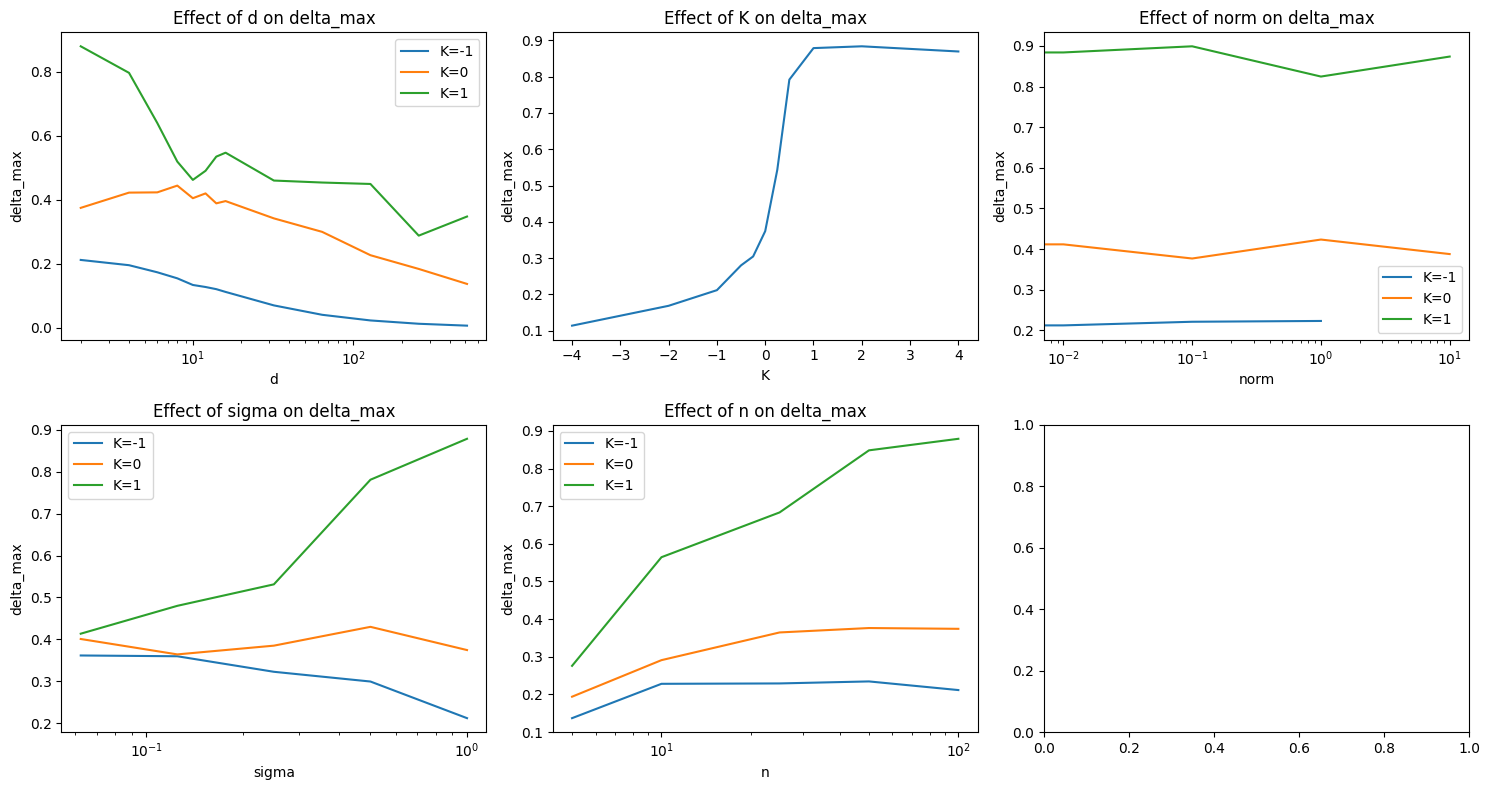

In [5]:
# Plot the effect of each variable on delta_mean

# COL = "delta_mean"
COL = "delta_max"
VARS = ["d", "K", "norm", "sigma", "n"]
DEFAULTS = {"d": 2, "K": -1, "norm": 0, "sigma": 1, "n": 100}
K_VALUES = [-1, 0, 1]  # Values of K to compare

fig, axs = plt.subplots(2, 3, figsize=FIGSIZE)
for var, ax in zip(VARS, axs.flatten()):
    ax.set_title(f"Effect of {var} on {COL}")

    if var == "K":
        # For K plot, use the defaults for other variables
        df_filtered = deltas.copy()
        for filter_var in VARS:
            if filter_var != var:
                df_filtered = df_filtered[df_filtered[filter_var] == DEFAULTS[filter_var]]

        df_grouped = df_filtered.groupby(var).mean()
        ax.plot(df_grouped.index, df_grouped[COL])

    else:
        # For other variables, plot multiple lines for different K values
        for k_val in K_VALUES:
            df_filtered = deltas.copy()
            for filter_var in VARS:
                if filter_var == var:
                    continue  # Skip the variable we're plotting on x-axis
                elif filter_var == "K":
                    df_filtered = df_filtered[df_filtered[filter_var] == k_val]
                else:
                    df_filtered = df_filtered[df_filtered[filter_var] == DEFAULTS[filter_var]]

            df_grouped = df_filtered.groupby(var).mean()
            ax.plot(df_grouped.index, df_grouped[COL], label=f"K={k_val}")

        ax.legend()

    # Improve axis labels
    ax.set_xlabel(var)
    ax.set_ylabel(COL)

    # Use log scale for dimension
    if var != "K":
        ax.set_xscale("log")

plt.tight_layout()

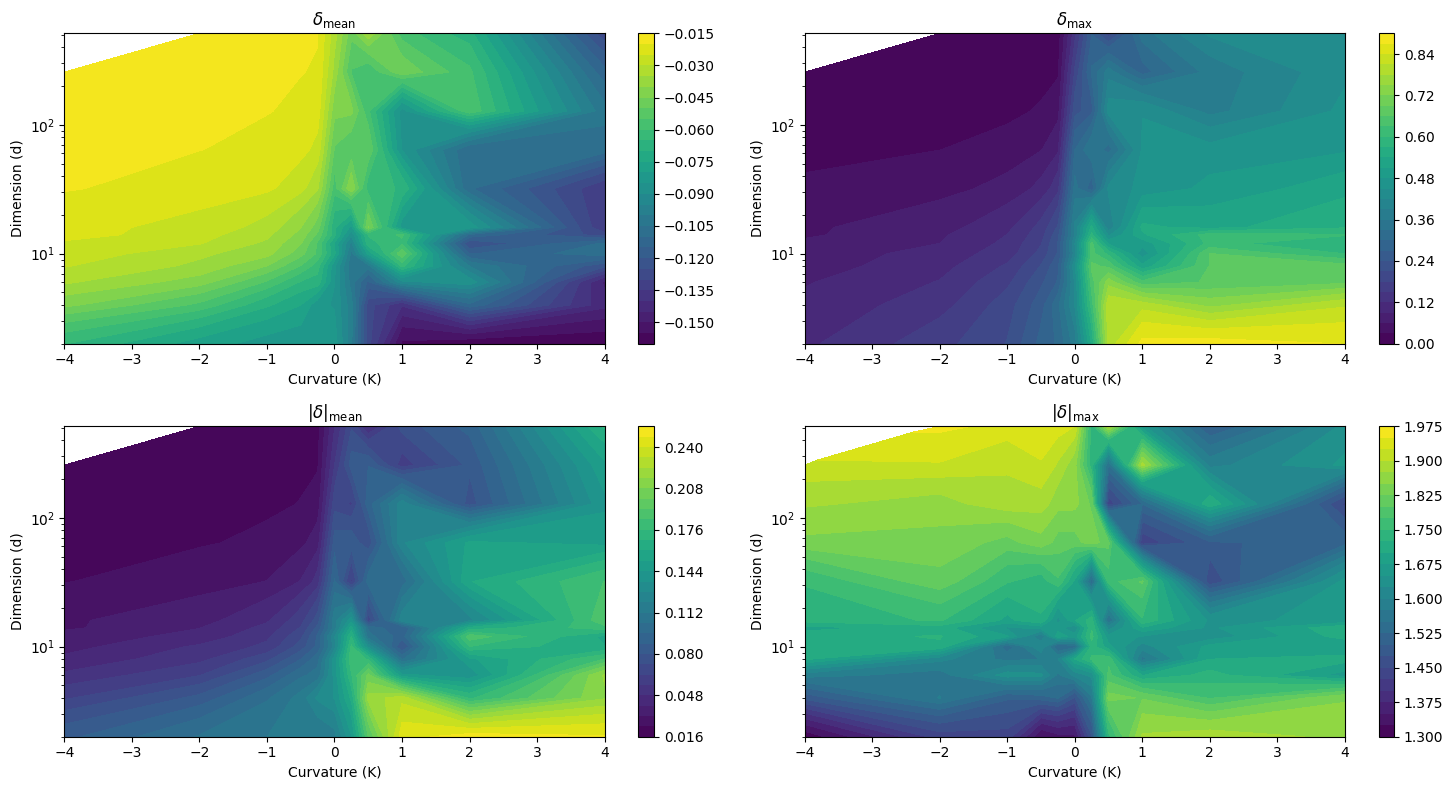

In [6]:
metrics = ["delta_mean", "delta_max", "delta_abs_mean", "delta_abs_max"]
names = [r"$\delta_\text{mean}$", r"$\delta_\text{max}$", r"$|\delta|_\text{mean}$", r"$|\delta|_\text{max}$"]

fig, axs = plt.subplots(2, 2, figsize=FIGSIZE)
for metric, ax, name in zip(metrics, axs.flatten(), names):
    piv = deltas[(deltas[["n", "sigma", "norm"]] == (100, 1, 0)).all(axis=1)].pivot_table(
        index="d", columns="K", values=metric
    )
    X = piv.columns.astype(float)
    Y = piv.index.astype(float)
    Z = piv.values

    cs = ax.contourf(X, Y, Z, levels=30, cmap="viridis")
    fig.colorbar(cs, ax=ax)

    ax.set_xscale("linear")
    ax.set_yscale("log")
    ax.set_xlabel("Curvature (K)")
    ax.set_ylabel("Dimension (d)")
    ax.set_title(name)

plt.tight_layout()
plt.show()